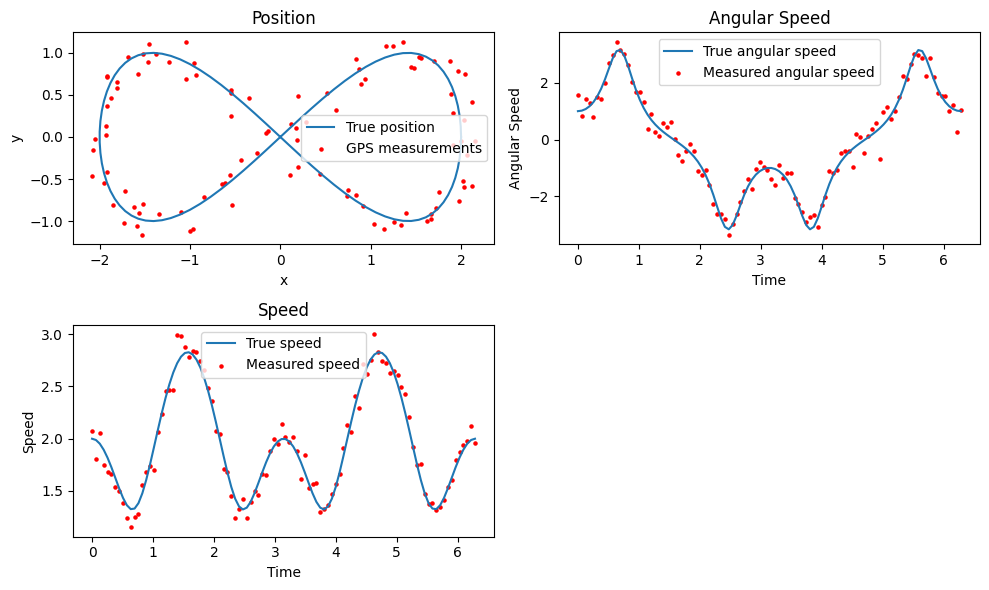

In [25]:

import matplotlib.pyplot as plt
import numpy as np

from numpy import pi, cos, sin, sqrt, diag
from numpy.linalg import inv
from numpy.random import randn


t = np.linspace(0, 2*pi, 100)
dt = t[1] - t[0]

# position
x = 2*cos(t)
y = sin(2*t)

# velocity
dxdt = -2*sin(t)
dydt = 2*cos(2*t)

# accel
d2xdt2 = -2*cos(t)
d2ydt2 = -4*sin(2*t)

# jerk
d3xdt3 = 2*sin(t)
d3ydt3 = -8*cos(2*t)

# angular speed (scalar)
omega = (dxdt*d2ydt2 - dydt*d2xdt2) / (dxdt**2 + dydt**2)

# speed (scalar)
speed = sqrt(dxdt**2 + dydt**2)

# measurement error
gps_sig = 0.1
omega_sig = 0.3
speed_sig = 0.1

# noisy measurements
x_gps = x + gps_sig * randn(*x.shape)
y_gps = y + gps_sig * randn(*y.shape)
omega_sens = omega + omega_sig * randn(*omega.shape)
speed_sens = speed + speed_sig * randn(*speed.shape)


# Plotting the position
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(x, y, label='True position')
plt.scatter(x_gps, y_gps, color='red', label='GPS measurements',s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Position')
plt.legend()

# Plotting the angular speed
plt.subplot(2, 2, 2)
plt.plot(t, omega, label='True angular speed')
plt.scatter(t, omega_sens, color='red', label='Measured angular speed',s=5)
plt.xlabel('Time')
plt.ylabel('Angular Speed')
plt.title('Angular Speed')
plt.legend()

# Plotting the speed
plt.subplot(2, 2, 3)
plt.plot(t, speed, label='True speed')
plt.scatter(t, speed_sens, color='red', label='Measured speed',s=5)
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
A = np.array([
    [1, dt, (dt**2)/2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, (dt**2)/2],
    [0, 0, 0, 0, 1, dt],
    [0, 0, 0, 0, 0, 1],
    ])

Q1 = np.array([(dt**3)/6, (dt**2)/2, dt, 0, 0, 0])
Q1 = np.expand_dims(Q1, 1)
Q2 = np.array([0, 0, 0, (dt**3)/6, (dt**2)/2, dt])
Q2 = np.expand_dims(Q2, 1)

j_var = max(np.var(d3xdt3), np.var(d3ydt3))
Q = j_var * (Q1 @ Q1.T + Q2 @ Q2.T)

H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    ])

R = diag(np.array([gps_sig**2, gps_sig**2]))

x_init = np.array([x[0], dxdt[0], d2xdt2[0], y[0], dydt[0], d2ydt2[0]])
P_init = 0.01 * np.eye(len(x_init))  # small initial prediction error

# create an observation vector of noisy GPS signals
observations = np.array([x_gps, y_gps]).T

# matrix dimensions
nx = Q.shape[0]
ny = R.shape[0]
nt = observations.shape[0]

# allocate identity matrix for re-use
Inx = np.eye(nx)

# allocate result matrices
x_pred = np.zeros((nt, nx))      # prediction of state vector
P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
x_est = np.zeros((nt, nx))       # estimation of state vector
P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
K = np.zeros((nt, nx, ny))       # Kalman Gain

# set initial prediction
x_pred[0] = x_init
P_pred[0] = P_init

# for each time-step...
for i in range(nt):

    # prediction stage
    if i > 0:
        x_pred[i] = A @ x_est[i-1]
        P_pred[i] = A @ P_est[i-1] @ A.T + Q

    # estimation stage
    y_obs = observations[i]
    K[i] = P_pred[i] @ H.T @ inv((H @ P_pred[i] @ H.T) + R)
    x_est[i] = x_pred[i] + K[i] @ (y_obs - H @ x_pred[i])
    P_est[i] = (Inx - K[i] @ H) @ P_pred[i]

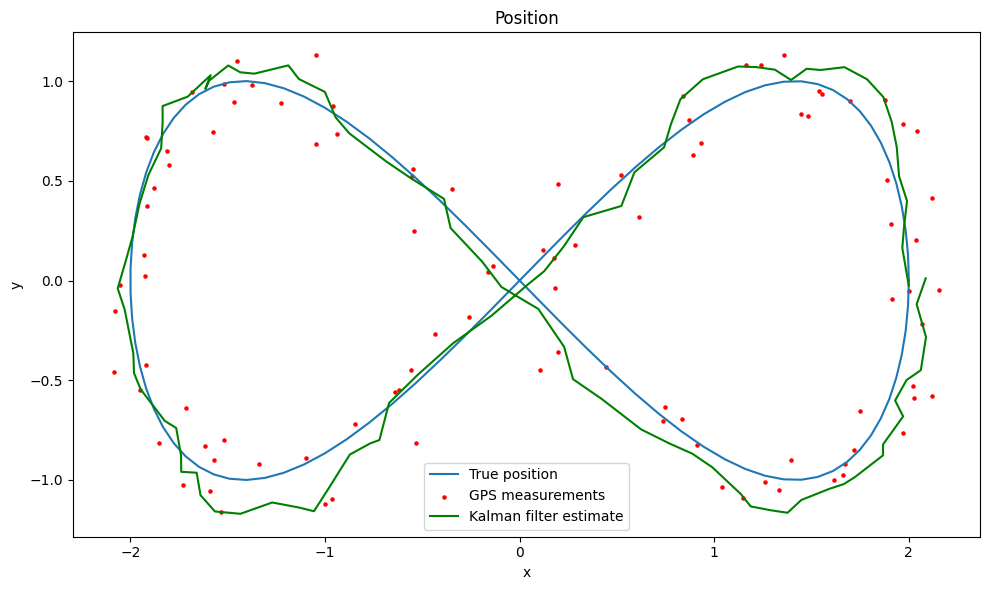

In [27]:
# Plotting the position
plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
plt.plot(x, y, label='True position')
plt.scatter(x_gps, y_gps, color='red', label='GPS measurements', s=5)
plt.plot(x_est[:, 0], x_est[:, 3], color='green', label='Kalman filter estimate')  # Plotting estimated position
plt.xlabel('x')
plt.ylabel('y')
plt.title('Position')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# create an observation vector of all noisy signals
observations = np.array([x_gps, y_gps, omega_sens, speed_sens]).T

# matrix dimensions
nx = Q.shape[0]
ny = R.shape[0]
nt = observations.shape[0]

# allocate identity matrix for re-use
Inx = np.eye(nx)

# allocate result matrices
x_pred = np.zeros((nt, nx))      # prediction of state vector
P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
x_est = np.zeros((nt, nx))       # estimation of state vector
P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
K = np.zeros((nt, nx, ny))       # Kalman Gain

# set initial prediction
x_pred[0] = x_init
P_pred[0] = P_init

# for each time-step...
for i in range(nt):

    # prediction stage
    if i > 0:
        x_pred[i] = A @ x_est[i-1]
        P_pred[i] = A @ P_est[i-1] @ A.T + Q

    # estimation stage
    y_obs = observations[i]
    y_pred = eval_h(x_pred[i])
    H_pred = eval_H(x_pred[i])
    K[i] = P_pred[i] @ H_pred.T @ inv((H_pred @ P_pred[i] @ H_pred.T) + R)
    x_est[i] = x_pred[i] + K[i] @ (y_obs - y_pred)
    P_est[i] = (Inx - K[i] @ H_pred) @ P_pred[i]

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\2192323501.py:7: RuntimeWarning: invalid value encountered in scalar divide
  w = (vx*ay - vy*ax) / (vx**2 + vy**2)
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\2192323501.py:21: RuntimeWarning: invalid value encountered in scalar divide
  dwdvx = (V2*ay - 2*vx*(vx*ay-vy*ax)) / (V2**2)
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\2192323501.py:22: RuntimeWarning: invalid value encountered in scalar divide
  dwdax = -vy / V2
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\2192323501.py:23: RuntimeWarning: invalid value encountered in scalar divide
  dwdvy = (-V2*ax - 2*vy*(vx*ay-vy*ax)) / (V2**2)
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\2192323501.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dwday = vx / V2
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\2192323501.py:27: RuntimeWarning: invalid value encountered in scalar divide
  dsdvx = vx / sqrt(V2)
C:\Users\DCLAB\AppData\Local\Temp\ipyke

In [21]:
def eval_h(x_pred):
    
    # expand prediction of state vector
    px, vx, ax, py, vy, ay = x_pred
    
    # compute angular vel
    w = (vx*ay - vy*ax) / (vx**2 + vy**2)
    
    # compute speed
    s = sqrt(vx**2 + vy**2)

    return np.array([px, py, w, s])

def eval_H(x_pred):
    
    # expand prediction of state vector
    px, vx, ax, py, vy, ay = x_pred
    V2 = vx**2 + vy**2
    
    # angular vel partial derivs
    dwdvx = (V2*ay - 2*vx*(vx*ay-vy*ax)) / (V2**2)
    dwdax = -vy / V2
    dwdvy = (-V2*ax - 2*vy*(vx*ay-vy*ax)) / (V2**2)
    dwday = vx / V2

    # speed partial derivs
    dsdvx = vx / sqrt(V2)
    dsdvy = vy / sqrt(V2)

    return np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, dwdvx, dwdax, 0, dwdvy, dwday],
        [0, dsdvx, 0, 0, dsdvy, 0],
        ])

# redefine R to include speedometer and gyro variances
R = diag(np.array([gps_sig**2, gps_sig**2, omega_sig**2, speed_sig**2]))

# create an observation vector of all noisy signals
observations = np.array([x_gps, y_gps, omega_sens, speed_sens]).T

# matrix dimensions
nx = Q.shape[0]
ny = R.shape[0]
nt = observations.shape[0]

# allocate identity matrix for re-use
Inx = np.eye(nx)

# allocate result matrices
x_pred = np.zeros((nt, nx))      # prediction of state vector
P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
x_est = np.zeros((nt, nx))       # estimation of state vector
P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
K = np.zeros((nt, nx, ny))       # Kalman Gain

# set initial prediction
x_pred[0] = x_init
P_pred[0] = P_init

# for each time-step...
for i in range(nt):

    # prediction stage
    if i > 0:
        x_pred[i] = A @ x_est[i-1]
        P_pred[i] = A @ P_est[i-1] @ A.T + Q

    # estimation stage
    y_obs = observations[i]
    y_pred = eval_h(x_pred[i])
    H_pred = eval_H(x_pred[i])
    K[i] = P_pred[i] @ H_pred.T @ inv((H_pred @ P_pred[i] @ H_pred.T) + R)
    x_est[i] = x_pred[i] + K[i] @ (y_obs - y_pred)
    P_est[i] = (Inx - K[i] @ H_pred) @ P_pred[i]

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\3928063974.py:7: RuntimeWarning: invalid value encountered in scalar divide
  w = (vx*ay - vy*ax) / (vx**2 + vy**2)
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\3928063974.py:21: RuntimeWarning: invalid value encountered in scalar divide
  dwdvx = (V2*ay - 2*vx*(vx*ay-vy*ax)) / (V2**2)
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\3928063974.py:22: RuntimeWarning: invalid value encountered in scalar divide
  dwdax = -vy / V2
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\3928063974.py:23: RuntimeWarning: invalid value encountered in scalar divide
  dwdvy = (-V2*ax - 2*vy*(vx*ay-vy*ax)) / (V2**2)
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\3928063974.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dwday = vx / V2
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_12632\3928063974.py:27: RuntimeWarning: invalid value encountered in scalar divide
  dsdvx = vx / sqrt(V2)
C:\Users\DCLAB\AppData\Local\Temp\ipyke

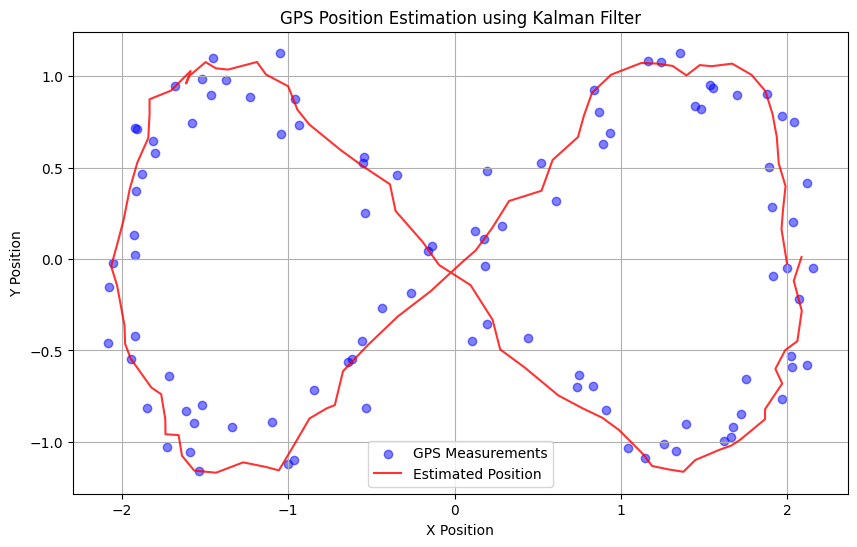

In [28]:

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot GPS measurements
plt.scatter(observations[:, 0], observations[:, 1], color='blue', label='GPS Measurements', alpha=0.5)

# Plot estimated positions
plt.plot(x_est[:, 0], x_est[:, 3], color='red', label='Estimated Position', alpha=0.8)

# Set labels and title
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('GPS Position Estimation using Kalman Filter')
plt.legend()
plt.grid(True)

# Show plot
plt.show()